<a href="https://colab.research.google.com/github/JieShengm/scTransformer_MAE/blob/main/%5BscTransformer%5Dzhengmix8eq_Gene_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prep

In [ ]:
cd /content/drive/MyDrive/scmae

/content/drive/MyDrive/scmae


In [ ]:
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from torchvision import transforms as pth_transforms
from PIL import Image

# check whether run in Colab
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install timm==0.4.5  # 0.3.2 does not work in Colab
    !pip3 install umap-learn
    !pip3 install scprep
    !pip3 install anndata
#    !git clone https://github.com/facebookresearch/mae.git
#    sys.path.append('./mae')
else:
    sys.path.append('..')
import models_mae

import umap
import math
import scprep

umap_operator = umap.UMAP(n_components=2) # n_components = 2: 2-dim umap 

Running in Colab.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 287 kB 13.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 5.4 MB/s 
     |████████████████████████████████| 1.1 MB 27.8 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=02583ef92c110fb3b33bbdb2f23bfd6d3361f70b46269acfed05132fdac575b5
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=5eb40a4fcb60d290d3d784128c99fc7696b16d9ca18e92d8525febb9575e9f8b
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
Successfully built umap-learn pynndescent
Looking in indexes: https://pypi.org/s

# Utils

In [ ]:
class Crop(object):

  def __call__(self, x):
    
    index = torch.from_numpy(np.arange(2000))
    vec = torch.cat([x, index]).float()

    return vec, x

In [ ]:
def prepare_model(chkpt_dir, arch='mae_vit_large_patch16', gene_embed_dim = 8, gene_number = 2000):
    # build model
    model = getattr(models_mae, arch)(gene_embed_dim = gene_embed_dim, gene_number = gene_number)
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    model.eval()
    return model

# Load Model

In [ ]:
pwd

'/content/drive/MyDrive/scmae'

In [ ]:
# download checkpoint if not exist
chkpt_dir = '/content/drive/MyDrive/scmae/checkpoint-4600.pth'
model_mae = prepare_model(chkpt_dir, 'mae_vit_d64', gene_embed_dim = 64, gene_number =10198)
print('Model loaded.')

<All keys matched successfully>
Model loaded.


# Gene Embeddings


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


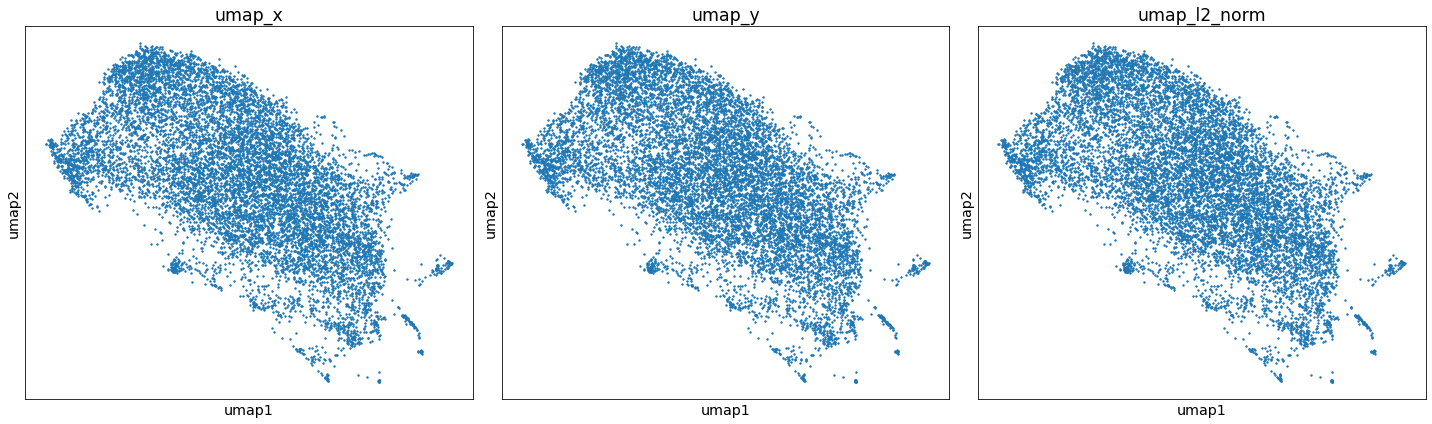

In [ ]:
## Secondly, calculate 784 pixels' embedding coordinates
## Also, you need to calculate/load ground truth coordinates:
x_cor = np.arange(784) // 28 - 14 # should be an array/series (784-dim vector)
y_cor = np.arange(784) % 28 - 14
max_norm = []
l2_norm = []
for i in range(784):
  max_norm.append(max(abs(x_cor[i]), abs(y_cor[i])))
  l2_norm.append(math.sqrt(x_cor[i]**2 + y_cor[i]**2))
max_norm = np.array(max_norm)
l2_norm = np.array(l2_norm)

pos_embed = model_mae.state_dict().get('pos_embed.weight')
Y_UMAP = umap_operator.fit_transform(pos_embed) 

### visualization ###
import matplotlib.pyplot as plt
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 6))

scprep.plot.scatter2d(Y_UMAP, label_prefix="umap", title="umap_x",
                       ticks=False, cmap='Spectral', ax=ax1)

scprep.plot.scatter2d(Y_UMAP, label_prefix="umap", title="umap_y",
                      ticks=False, cmap='Spectral', ax=ax2) 
scprep.plot.scatter2d(Y_UMAP, label_prefix="umap", title="umap_l2_norm",
                      ticks=False, cmap='Spectral', ax=ax3) 

plt.tight_layout()
plt.show()

In [ ]:
#np.savetxt("gene_embedding_dim64_epoch4600.csv", Y_UMAP, delimiter=",")

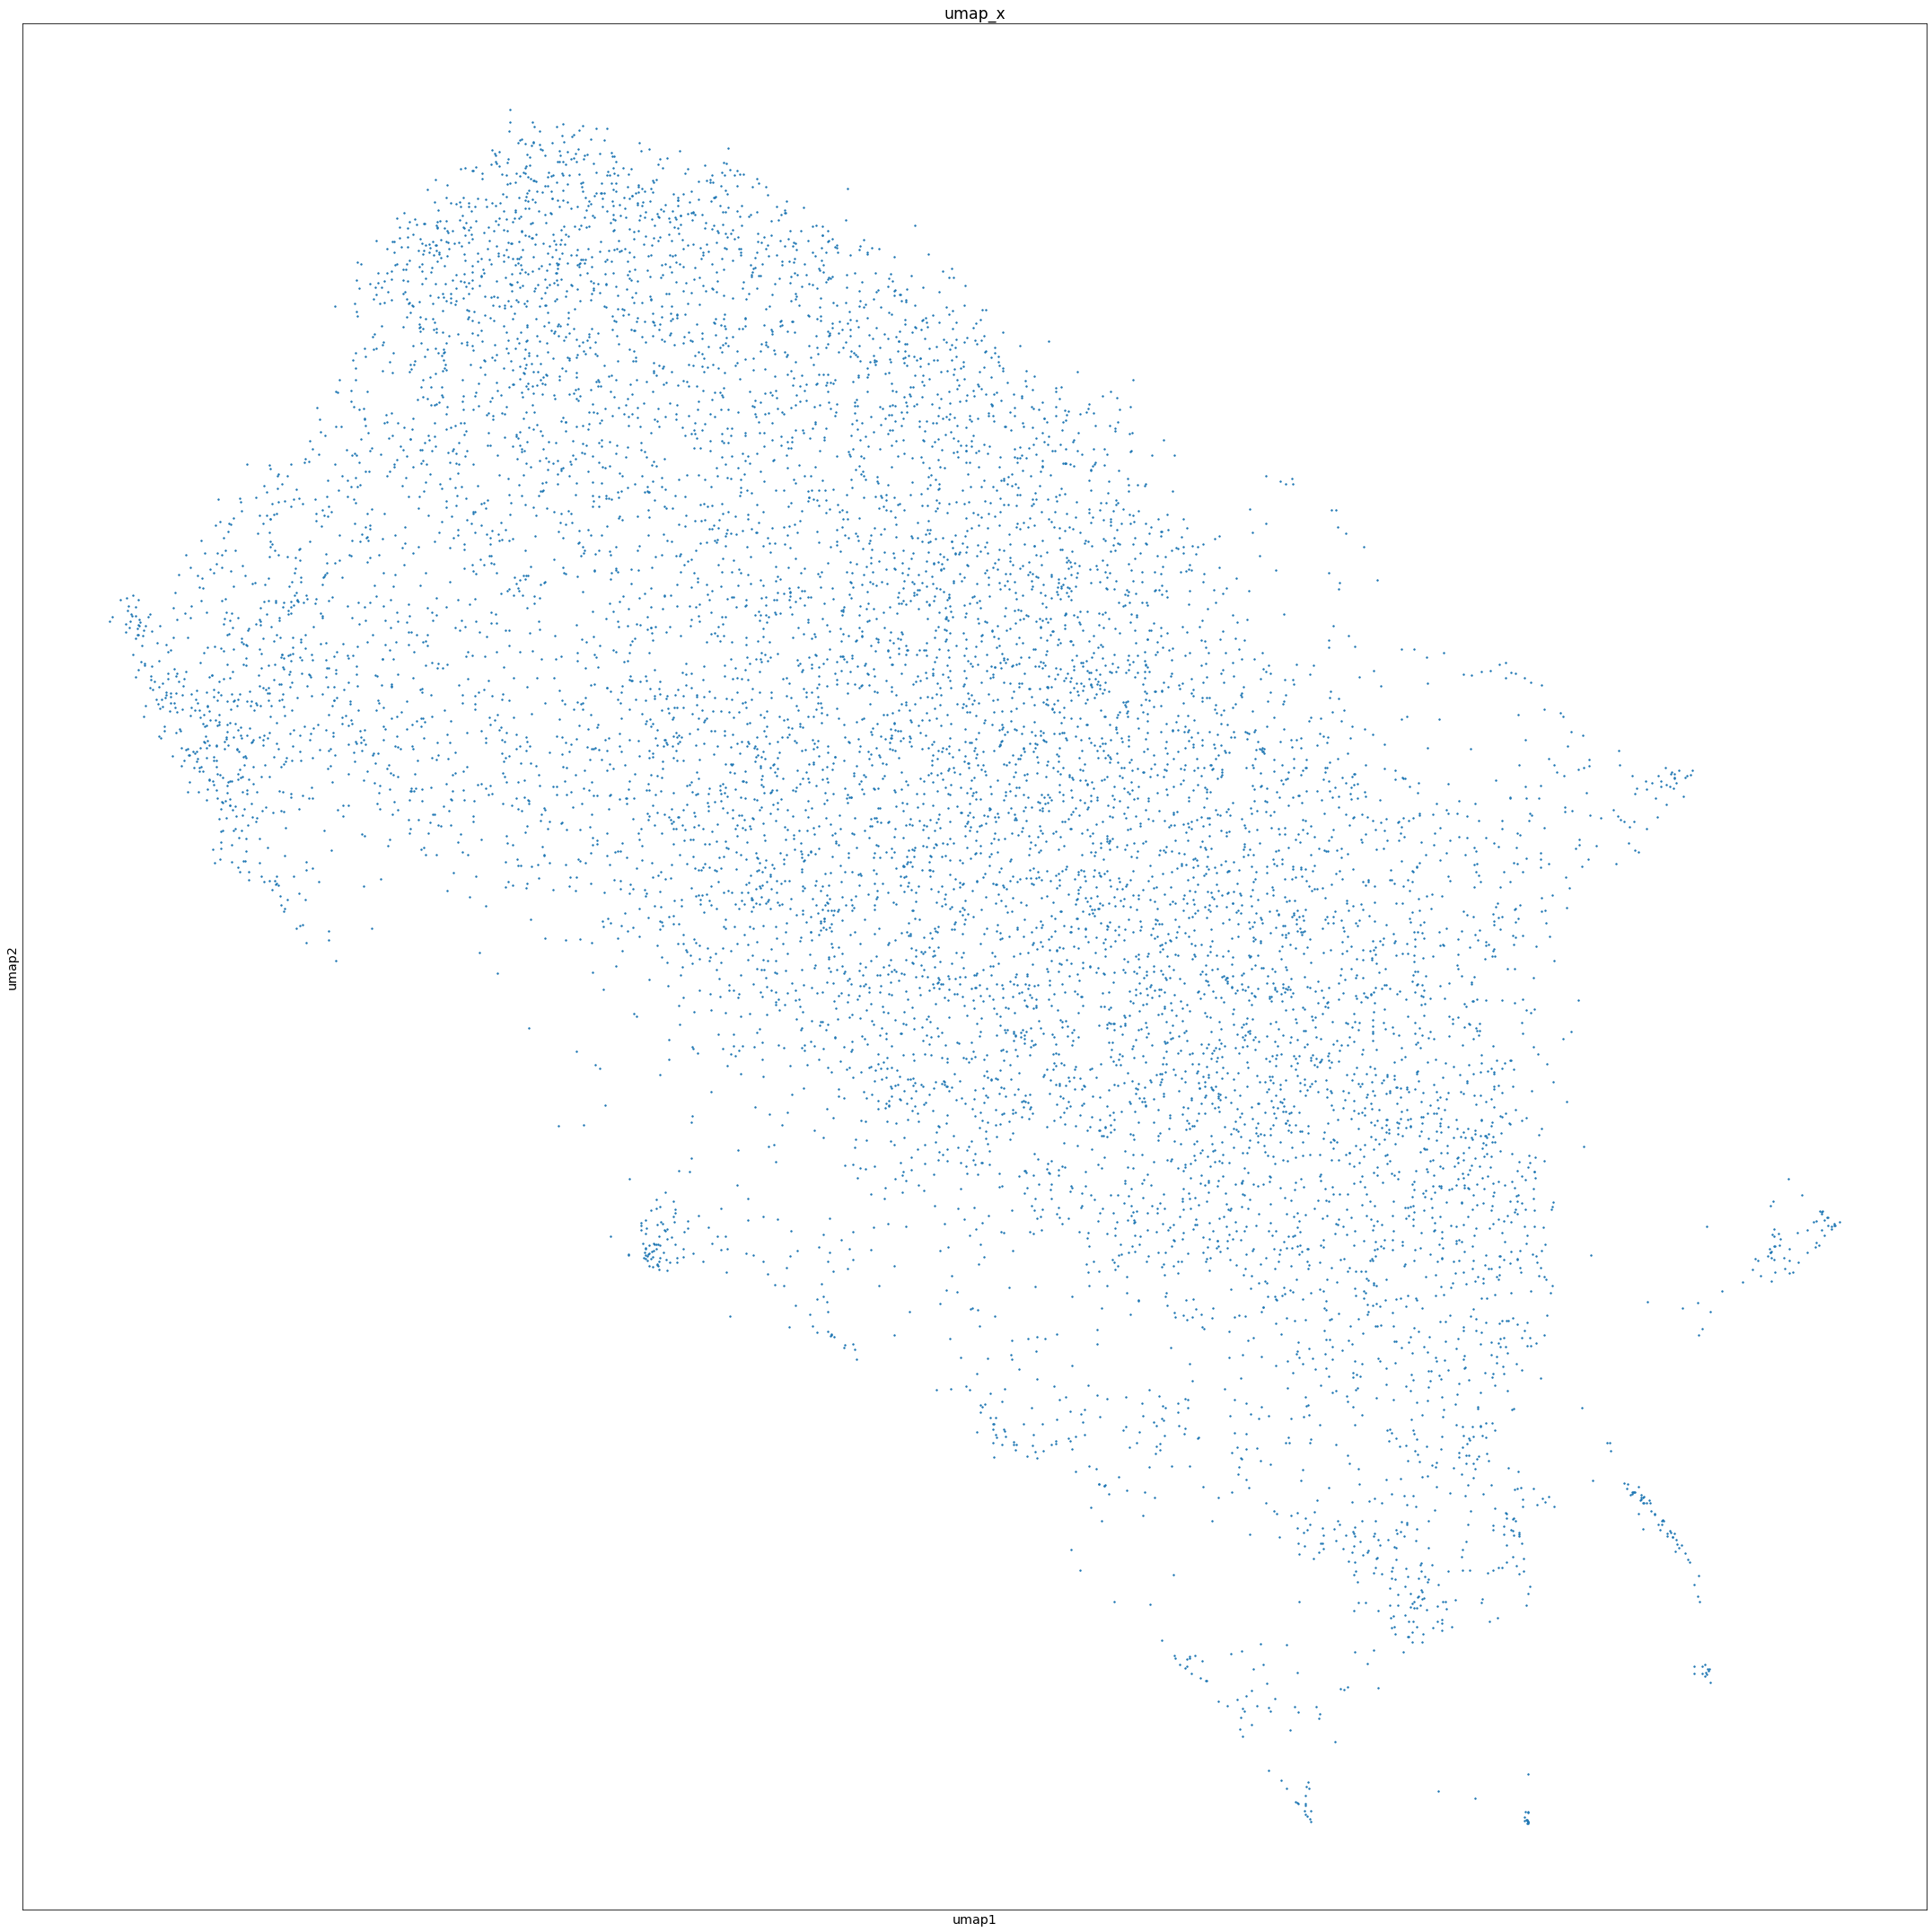

In [ ]:
scprep.plot.scatter2d(Y_UMAP, label_prefix="umap", title="umap_x",
                       ticks=False, cmap='Spectral',  figsize=(30,30))

In [ ]:
#np.savetxt("gene_vector_dim64_epoch4600.csv", np.array(pos_embed), delimiter=",")

In [ ]:
#import pickle
#with open("test_pickle.txt", "wb") as fp:   #Pickling
#   pickle.dump(pos_embed, fp)

In [ ]:
#with open("test_pickle.txt", "rb") as fp:   # Unpickling
#   b = pickle.load(fp)